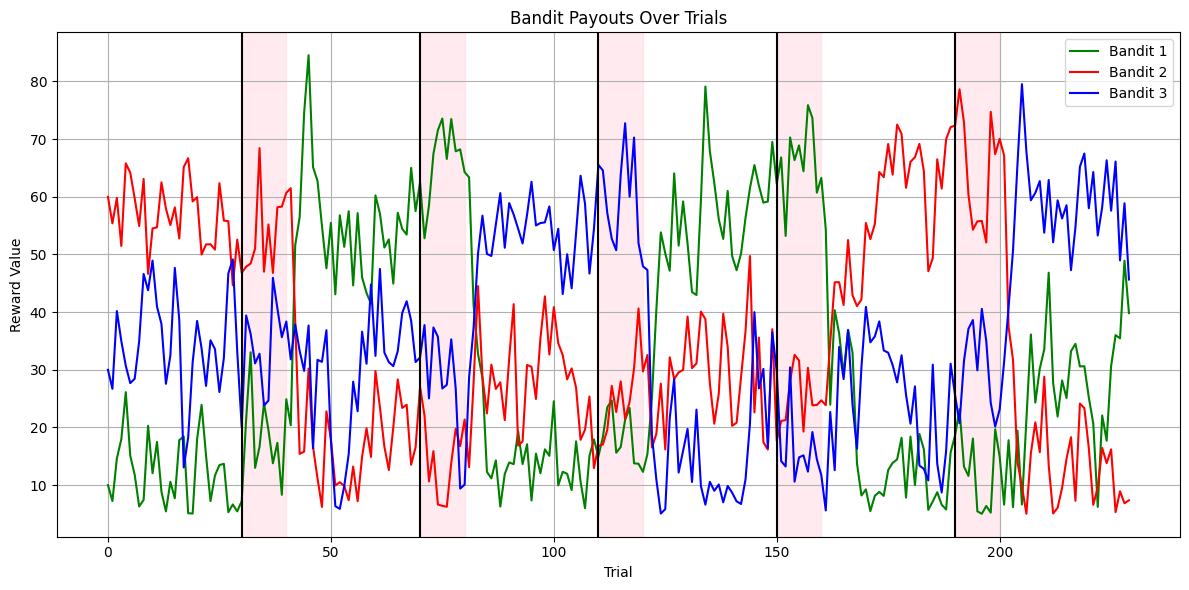

{1: array([0.1       , 0.07235946, 0.14638989, 0.17961349, 0.26126395,
        0.1509171 , 0.11785686, 0.06301313, 0.07425044, 0.20292557,
        0.12055001, 0.17485316, 0.08849915, 0.0543341 , 0.1057031 ,
        0.07717666, 0.17801475, 0.18419414, 0.05123874, 0.05068081,
        0.179895  , 0.23918012, 0.15117452, 0.07225223, 0.11663745,
        0.13465207, 0.13697769, 0.05299878, 0.06642328, 0.05441289,
        0.07226129, 0.21484282, 0.33038766, 0.1299499 , 0.16651138,
        0.24244525, 0.1954302 , 0.13778303, 0.17326982, 0.0832049 ,
        0.24887839, 0.20383404, 0.51610751, 0.56455953, 0.7454378 ,
        0.84548895, 0.65142101, 0.62774491, 0.54944331, 0.47595783,
        0.55480609, 0.43082193, 0.56789141, 0.51321118, 0.57496544,
        0.44632456, 0.57174156, 0.46015   , 0.43323733, 0.41453336,
        0.60239901, 0.57112987, 0.51200366, 0.52614087, 0.44939202,
        0.57231648, 0.54448034, 0.53445674, 0.65021131, 0.57522298,
        0.62514448, 0.52807481, 0.58479013, 0

In [50]:
import numpy as np

# ----- Constants -----
num_bandits = 3
block_len = 40
num_blocks = 6
num_trials = block_len * num_blocks * 2
init_payoff = [10, 60, 30]
decayTheta = init_payoff.copy()
payoff_bounds = [5, 95]
decay_lambda = 0.5
drift_noise = 8

rotation_trials = [40, 80, 120, 160, 200, 240, 280, 320, 360, 400, 440]
deterministic_trials = [30, 70, 110, 150, 190]

# Add bumped deterministic trials
ctx_bump = 2
for i in range(len(deterministic_trials)):
    for j in range(1, ctx_bump):
        trial_to_add = deterministic_trials[i] + j
        deterministic_trials.append(trial_to_add)

# ----- Functions -----
def normal_random():
    return np.random.normal(loc=0, scale=1)

def mean(x):
    return sum(x) / len(x)

def rotate_decayTheta(current_decayTheta):
    bestOpt = np.argmax(current_decayTheta)
    shuffled = current_decayTheta.copy()
    while np.argmax(shuffled) == bestOpt:
        np.random.shuffle(shuffled)
    return list(shuffled)

# ----- Initialize payout matrix -----
payout = np.zeros((num_bandits, num_trials))
for i in range(num_bandits):
    payout[i][0] = init_payoff[i]

# ----- Main drift loop -----
for trial_idx in range(num_trials):

    # ROTATION TRIALS: Change which bandit has the highest expected payoff
    if trial_idx in rotation_trials:
        decayTheta = rotate_decayTheta(decayTheta)

    # DETERMINISTIC TRIALS: Force the best bandit's value to 100
    if trial_idx in deterministic_trials:
        bestOpt = np.argmax(decayTheta)
        payout[bestOpt][trial_idx] = 100

    # DRIFT: Smooth payoff change from previous value
    if trial_idx > 0:
        decay_lambda_eff = 0.95 if trial_idx % block_len < 2 else decay_lambda

        for bandit in range(num_bandits):
            prev = payout[bandit][trial_idx - 1]
            theta = decayTheta[bandit]
            noise = normal_random() * drift_noise

            drifted = decay_lambda_eff * prev + (1 - decay_lambda_eff) * theta + noise

            # Reflect at bounds
            if drifted > payoff_bounds[1]:
                drifted = payoff_bounds[1] - (drifted - payoff_bounds[1])
            elif drifted < payoff_bounds[0]:
                drifted = payoff_bounds[0] + (payoff_bounds[0] - drifted)

            payout[bandit][trial_idx] = drifted

# Convert to list of lists if needed
payout_list = payout.tolist()

import matplotlib.pyplot as plt

# Assume `payout` is a 2D list or NumPy array: shape (3, num_trials)
# If you haven't already defined `payout`, run the generation code first.



probabilities = {
    1: payout[0] * 0.01,
    2: payout[1] * 0.01,
    3: payout[2] * 0.01
}
# Plotting
plt.figure(figsize=(12, 6))

# Plot each bandit's payout trajectory
plt.plot(payout[0][0:230], label='Bandit 1', color='green')
plt.plot(payout[1][0:230], label='Bandit 2', color='red')
plt.plot(payout[2][0:230], label='Bandit 3', color='blue')
for d in [30, 70, 110, 150, 190]:
    plt.axvspan(d,d+10, color='pink', alpha=0.3)
    plt.axvline(d,color='black')
# Formatting
plt.xlabel('Trial')
plt.ylabel('Reward Value')
plt.title('Bandit Payouts Over Trials')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
probabilities

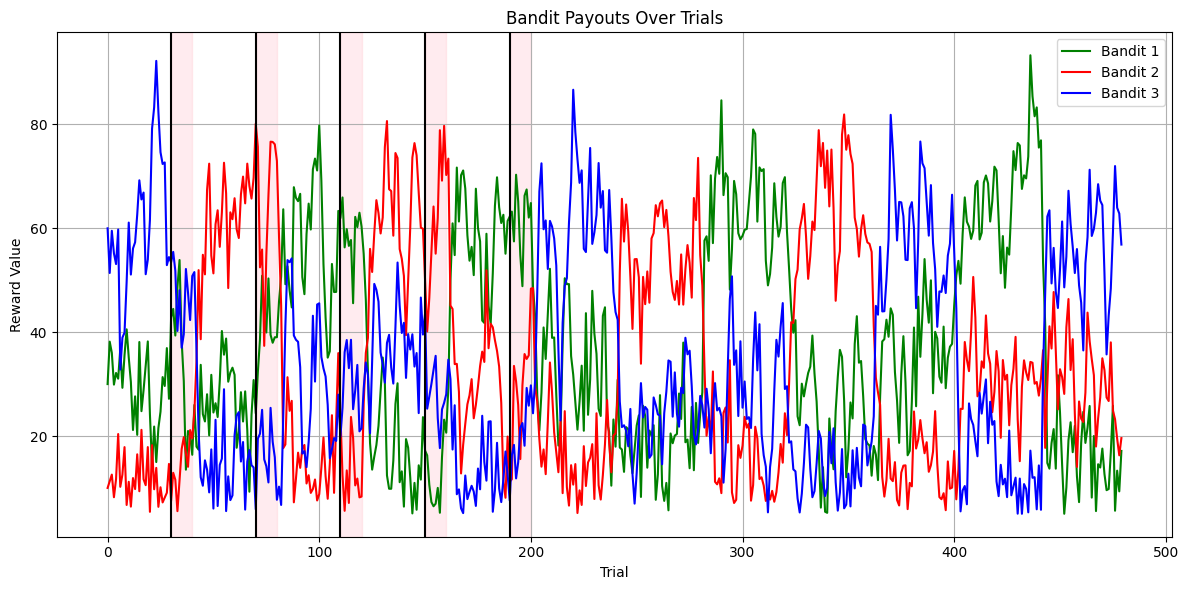

In [212]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot each bandit's payout trajectory
plt.plot(payout[0][0:], label='Bandit 1', color='green')
plt.plot(payout[1][0:], label='Bandit 2', color='red')
plt.plot(payout[2][0:], label='Bandit 3', color='blue')
for d in [30, 70, 110, 150, 190]:
    plt.axvspan(d,d+10, color='pink', alpha=0.3)
    plt.axvline(d,color='black')
# Formatting
plt.xlabel('Trial')
plt.ylabel('Reward Value')
plt.title('Bandit Payouts Over Trials')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
import pandas as pd

df = pd.DataFrame(probabilities)

# Optional: Rename columns if needed
df.columns = [f'Bandit_{i}' for i in df.columns]
# Assuming df already exists
# Define the scaling values by rank: 0 = highest
scale = {0: 0.6, 1: 0.3, 2: 0.1}

# Function to map each value in the row to its scaled reward
def rank_and_scale(row):
    ranks = row.rank(ascending=False, method='first') - 1  # 0 = highest, 2 = lowest
    return row.rank(ascending=False, method='first').sub(1).map(scale)

# Apply to each row
scaled_df = df[['Bandit_1', 'Bandit_2', 'Bandit_3']].apply(rank_and_scale, axis=1)

# Rename columns
scaled_df.columns = ['Bandit_1_scaled', 'Bandit_2_scaled', 'Bandit_3_scaled']

# Concatenate with original df
df = pd.concat([df, scaled_df], axis=1)
# Save to CSV
df.to_csv('/Users/rohinpalsule/Desktop/scaledpayout8.csv',index=False)

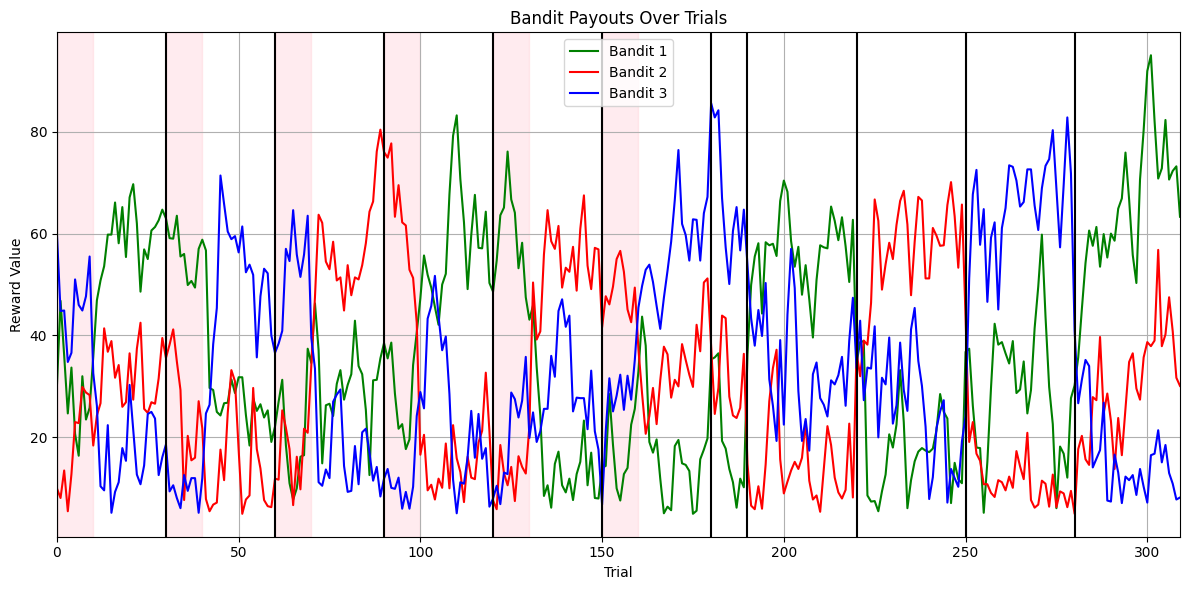

In [67]:
# Load the CSV file
import pandas as pd
payoutNum = np.random.randint(1,8)
df = pd.read_csv(f'/Users/rohinpalsule/Desktop/dmt-0958417638-probabilities.csv',header=None)  # Replace with your actual path

# Convert to probability dict
probabilities = {
    1: df[0].to_numpy(),
    2: df[1].to_numpy(),
    3: df[2].to_numpy()
}

# Not needed but in case needed
payout = {
    0: probabilities[1] / 0.01,
    1: probabilities[2] / 0.01,
    2: probabilities[3] / 0.01
}
# Plotting
plt.figure(figsize=(12, 6))

# Plot each bandit's payout trajectory
plt.plot(payout[0][0:], label='Bandit 1', color='green')
plt.plot(payout[1][0:], label='Bandit 2', color='red')
plt.plot(payout[2][0:], label='Bandit 3', color='blue')
for d in [0,30, 60, 90, 120, 150]:
    plt.axvspan(d,d+10, color='pink', alpha=0.3)
    plt.axvline(d,color='black')
plt.axvline(180,color='black')
plt.axvline(190,color='black')
plt.axvline(220,color='black')
plt.axvline(250,color='black')
plt.axvline(280,color='black')
plt.axvline(310,color='black')
# Formatting
plt.xlabel('Trial')
plt.ylabel('Reward Value')
plt.title('Bandit Payouts Over Trials')
plt.legend()
plt.grid(True)
plt.xlim(0,309)
plt.tight_layout()
plt.show()

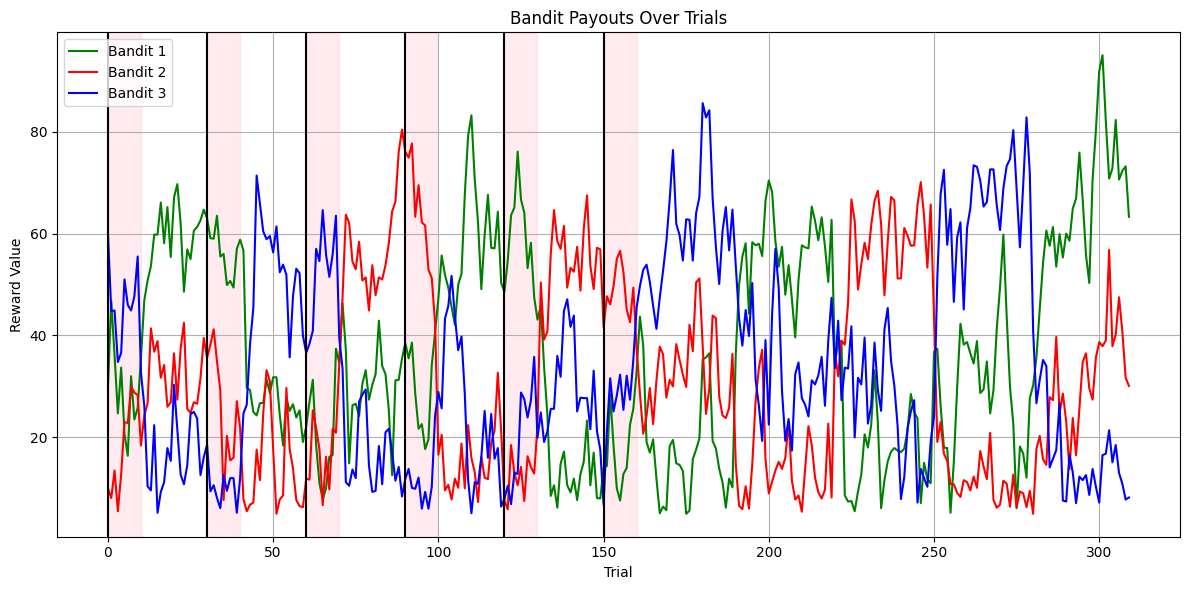

In [59]:
# Load the CSV file
import pandas as pd
payoutNum = np.random.randint(1,8)
df = pd.read_csv(f'/Users/rohinpalsule/Desktop/dmt-0958417638-probabilities.csv',header=None)  # Replace with your actual path

# Convert to probability dict
probabilities = {
    1: df[0].to_numpy(),
    2: df[1].to_numpy(),
    3: df[2].to_numpy()
}

# Not needed but in case needed
payout = {
    0: probabilities[1] / 0.01,
    1: probabilities[2] / 0.01,
    2: probabilities[3] / 0.01
}
# Plotting
plt.figure(figsize=(12, 6))

# Plot each bandit's payout trajectory
plt.plot(payout[0][0:], label='Bandit 1', color='green')
plt.plot(payout[1][0:], label='Bandit 2', color='red')
plt.plot(payout[2][0:], label='Bandit 3', color='blue')
for d in [0,30, 60, 90, 120, 150]:
    plt.axvspan(d,d+10, color='pink', alpha=0.3)
    plt.axvline(d,color='black')
# Formatting
plt.xlabel('Trial')
plt.ylabel('Reward Value')
plt.title('Bandit Payouts Over Trials')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [55]:
df

,0,1,2,3,4,5
0,0.300,0.100,0.600,0.3,0.1,0.6
1,0.468,0.081,0.448,0.3,0.1,0.6
2,0.361,0.135,0.449,0.3,0.1,0.6
3,0.247,0.055,0.348,0.3,0.1,0.6
4,0.337,0.128,0.366,0.3,0.1,0.6
...,...,...,...,...,...,...
305,0.823,0.402,0.185,0.6,0.3,0.1
306,0.706,0.475,0.130,0.6,0.3,0.1
307,0.723,0.408,0.109,0.6,0.3,0.1
308,0.732,0.317,0.078,0.6,0.3,0.1


In [17]:
image_prefix = "../run_exp/static/"
# Valid probes (seen in task) and Invalid (foils during memory phase)
valid_probe_images = []
invalid_probe_images = []
for i in range(1,231): # 230 trials (30 trials first block + 40 trials * 5 other blocks)
    if i < 10:   
        valid_probe_images.append(image_prefix + f"probes/probes-0{i}.png")
    else:
        valid_probe_images.append(image_prefix + f"probes/probes-{i}.png")
for i in range(231,256): # 25 trials (wrong probe trials during testing)
    invalid_probe_images.append(image_prefix + f"probes/probes-{i}.png")
contexts = [image_prefix + "contexts/context_coral_beach.png",
            image_prefix + "contexts/context_sunleaf_forest.png",
            image_prefix + "contexts/context_icecap_mountain.png",
            image_prefix + "contexts/context_driftwood_beach.png",
            image_prefix + "contexts/context_stonepine_forest.png",
            image_prefix + "contexts/context_greenrock_mountain.png"]
first_block = 30

# Init main phase image stacks
stacked_all_pirates = []
stacked_red_remember = []
stacked_red_reward = []
stacked_white_remember = []
stacked_white_reward = []
stacked_black_remember = []
stacked_black_reward = []
context_labels = []
stacked_planet_welcome = []
stacked_red_pirate = []
stacked_white_pirate = []
stacked_black_pirate = []
stacked_island_bye = []
stacked_island_nopirate = []
block_len_adjusted = 70
early_block = 30
for context_idx,context in enumerate(contexts):
    if context_idx == 0: # First context is 30 trials
        for trial_idx in range(first_block):
            stacked_red_remember.append([context,valid_probe_images[trial_idx]])
            stacked_red_reward.append([context,valid_probe_images[trial_idx]])
            context_labels.append(context.split("contexts/context_")[-1].split(".png")[0])
    else:
        for trial_idx in range(early_block,block_len_adjusted): # Rest of the contexts are 40 trials
            stacked_red_remember.append([context,valid_probe_images[trial_idx]])
            context_labels.append(context.split("contexts/context_")[-1].split(".png")[0])
        block_len_adjusted += 40
        early_block +=40
    print(context)



../run_exp/static/contexts/context_coral_beach.png
../run_exp/static/contexts/context_sunleaf_forest.png
../run_exp/static/contexts/context_icecap_mountain.png
../run_exp/static/contexts/context_driftwood_beach.png
../run_exp/static/contexts/context_stonepine_forest.png
../run_exp/static/contexts/context_greenrock_mountain.png
